# Initialize globals

In [0]:
import pandas as pd
import numpy as np
import os, glob, re

project_path = 'C:/Users/vap43/Documents/GitHub/reddit_comment_classification/'
TRAIN_DATA_PATH = project_path + "data/data_train.pkl"
TEST_DATA_PATH = project_path + "data/data_test.pkl"

# Import the text and classes

In [0]:
train_data = pd.read_pickle(TRAIN_DATA_PATH)
test_data  = pd.read_pickle(TEST_DATA_PATH)

nb_X_Train = len(train_data[0])
All_X = np.concatenate((np.array(train_data[0]),np.array(test_data)))
y = np.array(train_data[1])

In [57]:
print(All_X.shape)
print(nb_X_Train)

(100000,)
70000


# Pre-process the data

Remove stop words and stem

In [0]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stop_words_list = stopwords.words('english')
pattern = re.compile(r'\b\w\w+\b')

for idx, sentence in enumerate(All_X):
  #All_X[idx] = " ".join([stemmer.stem(word) for word in re.findall(pattern, sentence.lower()) if word not in stop_words_list])
  All_X[idx] = " ".join([word for word in re.findall(pattern, sentence.lower()) if word not in stop_words_list])

Count the terms

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
  ngram_range=(1, 1),
  min_df=3,
  max_features=None,
)
All_X_Counts = vectorizer.fit_transform(All_X)
print(All_X_Counts.shape)

(100000, 31953)


Weight the terms

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_transformer = TfidfVectorizer(
  ngram_range=(1, 1),
  min_df=2,
  max_features=None,
  strip_accents = "unicode",
  # sublinear_tf=True
)
All_X_ifidf = tfidf_transformer.fit_transform(All_X)
print(All_X_ifidf.shape)

(100000, 41899)


TODO: Reduce Dimensionality?

In [0]:
from 

Split out the Train/test data

In [0]:
X = All_X_ifidf[:nb_X_Train,:]
Kaggle_Test_X = All_X_ifidf[nb_X_Train:,:]

In [0]:
from sklearn.model_selection import train_test_split
# Train_X, Test_X, Train_y, Test_y = train_test_split(X,y, test_size=0.1, random_state=0, stratify=y)
Train_X, Train_y = X, y

In [111]:
from sklearn.naive_bayes import MultinomialNB

print(Train_X.shape)
print(Train_y.shape)

clf = MultinomialNB(alpha=0.3)
clf.fit(Train_X, Train_y)
clf.score(Test_X, Test_y)
#0.5725714285714286 sublinear_tf=True
#0.575 sublinear_tf=False

(63000, 41899)
(63000,)


0.5757142857142857


# Try out keras

In [0]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(Train_y.reshape(-1,1))
#onehot_encoded_test = onehot_encoder.transform(Test_y.reshape(-1,1))
y_onehot = onehot_encoder.transform(y.reshape(-1,1))

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, GaussianNoise
from keras.regularizers import l2
from keras.optimizers import Adagrad, Adam
from keras.constraints import max_norm

model = Sequential([
  # Input layer
  Dense(
    1024,
    use_bias=False,
    input_shape=(Train_X.shape[1],),
    #kernel_regularizer=l2(0.0001),
    kernel_constraint=max_norm(3.),
  ),
  BatchNormalization(),
  Activation('relu'),
  #Dropout(0.5),

  # # Hidden Layer
  # Dense(
  #   512,
  #   use_bias=False,
  #   kernel_regularizer=l2(0.001),
  #   kernel_constraint=max_norm(3.),
  # ),
  # BatchNormalization(),
  # Activation('relu'),
  # Dropout(0.5),

  # Output layer
  Dense(
    20,
    use_bias=False
  ),
  BatchNormalization(),
  Activation('softmax'),
])

model.compile(
  Adagrad(learning_rate=0.003),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

#model.fit(Train_X, onehot_encoded, epochs=1, batch_size=64, validation_data=(Test_X,onehot_encoded_test))
model.fit(X, y_onehot, epochs=1, batch_size=64)

Epoch 1/1
70000/70000 [==============================] - 84s 1ms/step - loss: 1.8367 - accuracy: 0.4948


In [0]:
y_onehot = model.predict(Kaggle_Test_X)

In [46]:
y_kaggle = onehot_encoder.inverse_transform(y_onehot)
y_kaggle = y_kaggle.squeeze()
print(y_kaggle.shape)

(30000,)


In [0]:
def create_and_save_submission(predictions, file_name="submission.csv"):
    ids = [i for i in range(len(predictions))]
    sub_df = pd.DataFrame(data=list(zip(ids, predictions)), columns=["Id","Category"])
    sub_df.to_csv(file_name, index=False)

create_and_save_submission(y_kaggle)

# Create a list of algorithms to test

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

names = ["Tree", "Forest","KNN","NB", "SVC", "AdaBoost", "log", "Bag", "Vote", "NN"]

classifiers = [
  DecisionTreeClassifier( **{'min_samples_leaf': 0.01, 'max_features': 1.0, 'max_depth': 100}),
  RandomForestClassifier( **{'n_estimators': 30, 'min_samples_leaf': 0.001, 'max_features': 1.0, 'max_depth': 100,}), #26.2% acc
  KNeighborsClassifier(   **{'weights': 'distance', 'p': 1, 'n_neighbors': 40}),
  MultinomialNB(          **{'alpha': 0.25}), # 0.569% acc
  LinearSVC(              **{'dual': False, 'C': 0.1}),
  AdaBoostClassifier(     **{'n_estimators': 100, 'learning_rate': 1.0}),
  LogisticRegression(     **{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'auto', 'max_iter': 100, 'C': 1.5} # 0.5446142857142857% acc 
  BaggingClassifier(base_estimator=LinearSVC(**{'C': 0.1})),
  # VotingClassifier(estimators=[
  #                              ('lsvc', LinearSVC(C=0.1)),
  #                              ('mnb', MultinomialNB(alpha=0.3)),
  #                              ('nn', MLPClassifier(**{'max_iter': 1, 'hidden_layer_sizes': (256,), 'batch_size': 64})),
  #                              ]), # 57.2% acc
  # VotingClassifier(estimators=[
  #                              ('lg',LogisticRegression(**{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'auto', 'max_iter': 100, 'C': 1.5})),
  #                              ('mnb', MultinomialNB(alpha=0.25)),
  #                              ('nn', MLPClassifier(**{'max_iter': 1, 'hidden_layer_sizes': (256,), 'batch_size': 64})),
  #                              ],
  #                  voting='soft',
  #                  weights=[1,1,1]), # 0.5755571428571429% acc
  VotingClassifier(estimators=[
                               ('lg',LogisticRegression(**{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'auto', 'max_iter': 100, 'C': 1.5})),
                               ('mnb', MultinomialNB(alpha=0.25)),
                               ('nn', MLPClassifier(**{'max_iter': 1, 'hidden_layer_sizes': (256,), 'batch_size': 64})),
                               ],
                   voting='soft',
                   weights=[54.3, 56.7, 57.3], # based on test fold accuracy
                   n_jobs=-1), # 0.5773428571428572% acc
  MLPClassifier(**{'max_iter': 1, 'hidden_layer_sizes': (256,), 'batch_size': 64}), # 0.5738000000000001% acc
]

for name, clf in zip(names, classifiers):
  if name not in ['']: continue
  scores = cross_val_score(clf, Train_X, Train_y, cv=4, scoring='accuracy',n_jobs=-1)
  print(name + ' Accuracy: ' + str(scores.mean()) + ' | std = ' + str(scores.std()))


# Choose the best hyperparameters for each algorithm

In [118]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import Audio
sound_file = 'C:/Users/vap43/AppData/Local/BlueJeans/current/Assets/Sounds/recording_stopped.mp3'

Tree_param = {
  'max_features'    : [0.01, 0.03, 0.1, 0.3, 1.0],
  'max_depth'       : [3, 10, 30, 100],
  'min_samples_leaf': [0.01, 0.03, 0.1, 0.3],
}

Forest_param = {
  'n_jobs'          : [1],
  'n_estimators'    : [10, 30, 100, 300],
  'max_features'    : [1.0],
  'max_depth'       : [3, 10, 30, 100],
  'min_samples_leaf': [0.001, 0.003, 0.01, 0.03, 0.1],
}

knn_param = {
  'n_neighbors' : [1,3,10,20,40,60],
  'weights'     : ['uniform', 'distance'],
  'p'           : [1, 2],
}

nb_param = {
  'alpha' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
}

svc_param = {
  #'kernel'        : ["linear"],
  'C'             : [0.01, 0.03, 0.063, 0.83, 0.1, 0.12, 0.15, 0.2, 0.3, 1.0],
  'dual'          : [False],
}

ada_param = {
  # 'n_estimators'  : [20, 50, 100],
  # 'learning_rate' : [0.01, 0.03, 0.1, 0.3, 1.0],
  'n_estimators'  : [100],
  'learning_rate' : [1.0],
}

log_param = {
  'penalty'     : ['l2'],
  'solver'      : ['lbfgs'],
  'multi_class' : ['auto'],
  'C'           : [0.3, 0.63, 1.0, 1.25, 1.5, 1.75, 2.0],
  'max_iter'    : [100, 300]
}

bag_param = {
    'base_estimator' : [LinearSVC(C=0.1), LinearSVC(C=0.3), LinearSVC(C=1.0)],
    'max_features'   : [0.3, 0.6, 1.0],
    'max_samples'    : [0.3, 0.6, 1.0],
}

vote_param = {
    'estimators' : [[
      ('lg',LogisticRegression(**{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'auto', 'max_iter': 100, 'C': 1.5})),
      ('mnb', MultinomialNB(alpha=0.25)),
      ('nn', MLPClassifier(**{'max_iter': 1, 'hidden_layer_sizes': (256,), 'batch_size': 64})),
    ]],
    'n_jobs' : [-1],
    'voting' : ['soft'],
    'weights' : [[1,1,1], [54.3, 56.7, 57.3]],
}

nn_param = {
    'max_iter'           : [1],
    'hidden_layer_sizes' : ((64,), (128,), (256,), (512,), (1024,)),
    'batch_size'         : [64],
}

grid_parameters = [
  Tree_param,
  Forest_param,
  knn_param,
  nb_param,
  svc_param,
  ada_param,
  log_param,
  bag_param,
  vote_param,
  nn_param
]

for name, clf, grid_params in zip(names, classifiers, grid_parameters):
  if name not in ['Vote']: continue
  gd_sr = RandomizedSearchCV(
    estimator=clf,
    param_distributions=grid_params,
    scoring='accuracy',
    cv=4,
    n_jobs=-1,
    n_iter=20
  )
  gd_sr.fit(Train_X, Train_y)
  best_parameters = gd_sr.best_params_
  best_result = gd_sr.best_score_
  print(name, best_result, best_parameters)

Audio(sound_file, autoplay=True)
# Bag 0.5571428571428572 {'max_samples': 0.6, 'max_features': 1.0, 'base_estimator': LinearSVC(C=0.1

C:\Users\vap43\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Vote 0.5773428571428572 {'weights': [54.3, 56.7, 57.3], 'voting': 'soft', 'n_jobs': -1, 'estimators': [('lg', LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)), ('mnb', MultinomialNB(alpha=0.25, class_prior=None, fit_prior=True)), ('nn', MLPClassifier(activation='relu', alpha=0.0001, batch_size=64, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(256,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=F

# Export Sklearn model: predict on Kaggle set

In [0]:
clf = VotingClassifier(estimators=[
    ('lg',LogisticRegression(**{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'auto', 'max_iter': 100, 'C': 1.5})),
    ('mnb', MultinomialNB(alpha=0.25)),
    ('nn', MLPClassifier(**{'max_iter': 1, 'hidden_layer_sizes': (256,), 'batch_size': 64})),
  ],
  voting='soft',
  weights=[54.3, 56.7, 57.3], # based on test fold accuracy
  n_jobs=-1
)

In [120]:
print(X.shape)
print(y.shape)
clf.fit(X, y) # Fit all training data

(70000, 41899)
(70000,)


VotingClassifier(estimators=[('lg',
                              LogisticRegression(C=1.5, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('mnb',
                              MultinomialNB(alpha=0.25, class_prior=None,
                                            fit_prior=True)),
                             ('nn',
                              MLPCla...
                                         

In [121]:
Kaggle_y_pred = clf.predict(Kaggle_Test_X)
print(Kaggle_y_pred.shape)

(30000,)


In [0]:
def create_and_save_submission(predictions, file_name="submission.csv"):
    ids = [i for i in range(len(predictions))]
    sub_df = pd.DataFrame(data=list(zip(ids, predictions)), columns=["Id","Category"])
    sub_df.to_csv(file_name, index=False)

create_and_save_submission(Kaggle_y_pred)

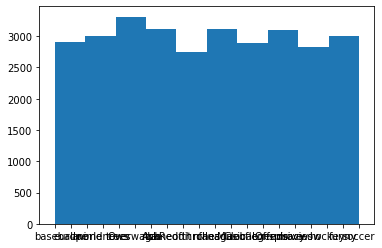

In [127]:
# TODO: Force class weights to be 5% likely?
import matplotlib.pyplot as plt
plt.hist(Kaggle_y_pred)
plt.show()